# A simple Example of Continual Learning with Generative Replay

Generative Replay is a continual learning method that use a generative models to generate samples from past experiences. The idea is : by learning from actual data and generated data from the past we can learn without forgetting.

In this notebook, we take on of the simpliest setting : Mnist disjoint - 10 tasks

In the setting, we have 10 task with each time one class per task. There is no overlapping between task, and we can not use data from past tasks. 

The goal is to train a generative model to generate all the 10 classes of mnist even if a receive data from each classes one by one.

To do so we use Generative Replay !

- **At task 0 (T0) :**  We train a generator on real data (for Mnist only samples of 0 ) only and then we save it as G0. G0 will be used as a memory of T0.
- **At task 1 (T1) :**  We clone G0 as G1 and we train it with both real data (samples of 1) and generated data of T0 with G0. At the end of the task G1 learned to generate both 0 and 1. Then we delete G0, G1 will be use as a memory for **both** T0 and T1
- **At task 2 (T2) :** We clone G1 as G2 and ...

After 10 task if the generative models is efficient we are able to generate all the 10 classes by this method. (Here by default we will only train on 3 tasks but you can easily modify the notebook to do all the 10 tasks :) )

In this notebook we only train a generative model to experiment how it works, but this method could also be use to realize an efficient memory for classification algorithms or reinforcement learning algorithms !!


Let's start !

1. We Create the environment to execute the code, we install pytorch with cuda 8.0 for GPU acceleration.

In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' #'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
print('Platform:', platform, 'Accelerator:', accelerator)

!pip install --upgrade --force-reinstall -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision

import torch
print('Torch', torch.__version__, 'CUDA', torch.version.cuda)

Platform: cp36-cp36m Accelerator: cu80
tcmalloc: large alloc 1073750016 bytes == 0x5ba4c000 @  0x7ff44315c2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
pymc3 3.6 has requirement joblib<0.13.0, but you'll have joblib 0.13.0 which is incompatible.
jupyter-console 6.0.0 has requirement prompt-toolkit<2.1.0,>=2.0.0, but you'll have prompt-toolkit 1.0.15 which is incompatible.
google-colab 0.0.1a1 has requirement six~=1.11.0, but you'll have six 1.12.0 which is incompatible.
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
cufflinks 0.14.6 has requirement plotly>=3.0.0, but you'll have plotly 1.12.12 which is incompatible.
Torch 0.4.0 CUDA 8.0.61


2. We import all library needed for training and visualisation

In [0]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
from copy import deepcopy

3. We clone the continualAI repo ta get an easy to use data loader for mnist

In [0]:
!git clone https://github.com/ContinualAI/colab.git continualai/colab

Cloning into 'continualai/colab'...
remote: Enumerating objects: 84, done.
remote: Total 84 (delta 0), reused 0 (delta 0), pack-reused 84
Unpacking objects: 100% (84/84), done.


4. We import mnist and inialize it

In [0]:
!ls colab

extras	LICENSE  notebooks  README.md  scripts


In [0]:
from continualai.colab.scripts import mnist
mnist.init()

Download complete.
Save complete.


5. We can now load the data set and get training and testing data and labels

In [0]:
x_train, t_train, x_test, t_test = mnist.load()

print("x_train dim and type: ", x_train.shape, x_train.dtype)
print("t_train dim and type: ", t_train.shape, t_train.dtype)
print("x_test dim and type: ", x_test.shape, x_test.dtype)
print("t_test dim and type: ", t_test.shape, t_test.dtype)

x_train dim and type:  (60000, 1, 28, 28) float32
t_train dim and type:  (60000,) uint8
x_test dim and type:  (10000, 1, 28, 28) float32
t_test dim and type:  (10000,) uint8


6. We set a flag to use cuda for GPU acceleration and we fix the seed for reproducibility purpose

In [0]:
# switch to False to use CPU
use_cuda = True

use_cuda = use_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu");
torch.manual_seed(1);

7. Creation of a generator. We will use a GAN to achieve Generative Replay.

In [0]:
class Generator(nn.Module):
    # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
    # Architecture : FC1024_BR-FC7x7x128_BR-(64)4dc2s_BR-(1)4dc2s_S
    def __init__(self):
        super(Generator, self).__init__()

        self.latent_dim = 1024
        self.input_height = 28
        self.input_width = 28
        self.input_dim = 62
        self.output_dim = 1

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, self.latent_dim),
            nn.BatchNorm1d(self.latent_dim),
            nn.ReLU(),
            nn.Linear(self.latent_dim, 128 * (self.input_height // 4) * (self.input_width // 4)),
            nn.BatchNorm1d(128 * (self.input_height // 4) * (self.input_width // 4)),
            nn.ReLU(),
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, self.output_dim, 4, 2, 1),
            nn.Sigmoid(),
        )

        self.maxPool = nn.MaxPool2d((2, 2), stride=(2, 2))
        self.Sigmoid = nn.Sigmoid()
        self.apply(self.weights_init)
    
    def reinit(self):
      self.apply(self.weights_init)

    def forward(self, input):
        input = input.view(-1, self.input_dim)
        x = self.fc(input)
        x = x.view(-1, 128, (self.input_height // 4), (self.input_width // 4))
        x = self.deconv(x)
        return x

    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            m.weight.data.normal_(0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            m.weight.data.normal_(1.0, 0.02)
            m.bias.data.fill_(0)

7. Here is the Discriminator of our GAN

In [0]:
class Discriminator(nn.Module):
    # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
    # Architecture : (64)4c2s-(128)4c2s_BL-FC1024_BL-FC1_S
    def __init__(self):
        super(Discriminator, self).__init__()
        self.input_height = 28
        self.input_width = 28
        self.input_dim = 1
        self.output_dim = 1

        self.latent_dim = 1024

        shape = 128 * (self.input_height // 4) * (self.input_width // 4)

        self.fc1_1 = nn.Linear(784, self.latent_dim)
        self.fc1_2 = nn.Linear(10, self.latent_dim)
        self.fc2 = nn.Linear(self.latent_dim * 2, self.latent_dim // 2)
        self.fc2_bn = nn.BatchNorm1d(self.latent_dim // 2)
        self.fc3 = nn.Linear(self.latent_dim // 2, 256)
        self.fc3_bn = nn.BatchNorm1d(256)
        self.fc4 = nn.Linear(256, 1)

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(shape, self.latent_dim),
            nn.BatchNorm1d(self.latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(self.latent_dim, self.output_dim),
            nn.Sigmoid(),
        )
        self.aux_linear = nn.Linear(shape, 10)
        self.softmax = nn.Softmax()
        self.apply(self.weights_init)
    
    def reinit(self):
      self.apply(self.weights_init)

    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            m.weight.data.normal_(0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            m.weight.data.normal_(1.0, 0.02)
            m.bias.data.fill_(0)

    def forward(self, input):
        x = self.conv(input)
        x = x.view(x.data.shape[0], 128 * (self.input_height // 4) * (self.input_width // 4))
        return self.fc(x)

8. The function get_iter_dataset makes possible to load data from only one particular class. It will help to load data class by class.

In [0]:
# function to get digits from only one class
def get_iter_dataset(x_train, t_train, classe=None):
    if classe is not None:
        return x_train[np.where(t_train==classe)[0]]

9. The function "run_batch" train the Generator and Discriminator one a particular batch of data.

In [0]:
def run_batch(G, D, G_optimizer, D_optimizer, x_):
      x_ = x_.view((-1, 1, 28, 28))
    
      # y_real and y_fake are the label for fake and true data
      y_real_ = Variable(torch.ones(x_.size(0), 1))
      y_fake_ = Variable(torch.zeros(x_.size(0), 1))
      if use_cuda:
        y_real_, y_fake_ = y_real_.cuda(0), y_fake_.cuda(0)

      z_ = torch.rand((x_.size(0), z_dim))

      x_, z_ = Variable(x_), Variable(z_)

      if use_cuda:
        x_, z_ = x_.cuda(0), z_.cuda(0)

      # update D network
      D_optimizer.zero_grad()

      D_real = D(x_)
      D_real_loss = BCELoss(D_real, y_real_[:x_.size(0)])

      G_ = G(z_)
      D_fake = D(G_)
      D_fake_loss = BCELoss(D_fake, y_fake_[:x_.size(0)])

      D_loss = D_real_loss + D_fake_loss

      D_loss.backward()
      D_optimizer.step()

      # update G network
      G_optimizer.zero_grad()

      G_ = G(z_)
      D_fake = D(G_)
      G_loss = BCELoss(D_fake, y_real_[:x_.size(0)])

      G_loss.backward()
      G_optimizer.step()

In [0]:
#Declarations and Hyper-parameters

# Training hyper-parameter
nb_task = 3  # change this to 10 if you want the experiment of the full 10 classes setting
batch_size = 64
lr = 0.0002
z_dim = 62
epoch_number = 10
nb_samples = 10

G = Generator()
D = Discriminator()

# G and D are put in train mode
G.train()
D.train()

if use_cuda:
  G.cuda(0)
  D.cuda(0)

# Use of Adam optimizer 
G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)
BCELoss = nn.BCELoss()

### Training Generator without Replay
In the following cell we train the generator without using Generative Replay. It show what happen when the catastrophics forgetting appear. Each line of samples is ramdomly sampled from the generator at the end of each task. We can see that at the end of each task the generator is only able to generate data from the present and not anymore from the past task. 

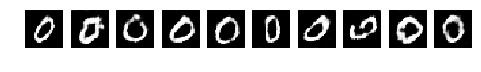

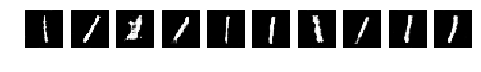

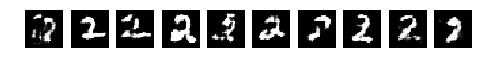

In [0]:
for task in range(nb_task):
  
  data = get_iter_dataset(x_train, t_train, classe=task)
  nb_batch = int(len(data)/batch_size)
  
  for epoch in range(epoch_number):
    for index in range(nb_batch):
      x_=torch.FloatTensor(data[index*batch_size:(index+1)*batch_size])
      run_batch(G, D, G_optimizer, D_optimizer, x_)

  
  z_ = Variable(torch.rand((nb_samples, z_dim)))
  
  if use_cuda:
    z_ = z_.cuda(0)
  samples = G(z_).data
  samples = samples.cpu().numpy()
  #plt.plot(samples[0])
  
  f, axarr = plt.subplots(1,nb_samples)
  for j in range(nb_samples):
    axarr[j].imshow(samples[j, 0], cmap="gray")
  np.vectorize(lambda ax:ax.axis('off'))(axarr);

10. This function help to generate replayed data from the GAN use as memory (Gt-1)

In [0]:
# New function to generate samples for replay
def get_replay(generator, batchsize):
  z_ = Variable(torch.rand((batchsize, z_dim)))
  if use_cuda:
    z_ = z_.cuda(0)
  return generator(z_).cpu()

###Training Generator with Replay

After seeing what happend when training without Generative Replay, we can now see how efficient generative replay is in this setting.

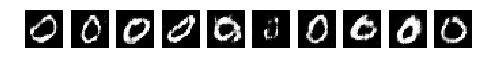

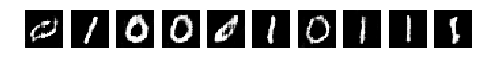

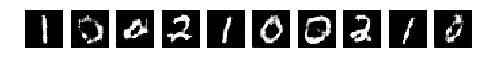

In [0]:
# We reinit D and G to not cheat
G.reinit()
D.reinit()

for task in range(nb_task):
  
  data = get_iter_dataset(x_train, t_train, classe=task)
  nb_batch = int(len(data)/batch_size)
  
  for epoch in range(epoch_number):
    for index in range(nb_batch):
      x_=torch.FloatTensor(data[index*batch_size:(index+1)*batch_size])
       
      if task > 0 :
        # We concat a batch of previously learned data
        # the more there is past task more data need to be regenerate
        replay = get_replay(G_saved, batch_size*task)
        x_=torch.cat((x_,replay),0)
      
      
      run_batch(G, D, G_optimizer, D_optimizer, x_)
      
  G_saved = deepcopy(G)
  
  z_ = Variable(torch.rand((nb_samples, z_dim)))
  
  if use_cuda:
    z_ = z_.cuda(0)
  samples = G(z_).data
  samples = samples.cpu().numpy()
  #plt.plot(samples[0])
  
  f, axarr = plt.subplots(1,nb_samples)
  for j in range(nb_samples):
    axarr[j].imshow(samples[j, 0], cmap="gray")
  np.vectorize(lambda ax:ax.axis('off'))(axarr);

### Bibliographie

**Generative Models from the perspective of Continual Learning**
*Timothee Lesort, Hugo Caselles-Dupre, Michael Garcia-Ortiz,  Andrei Stoian  and David Filliat*

```
@ARTICLE{2018arXiv181209111L,
       author = {{Lesort}, Timoth{\'e}e and {Caselles-Dupr{\'e}}, Hugo and {Garcia-
        Ortiz}, Michael and {Stoian}, Andrei and {Filliat}, David},
        title = "{Generative Models from the perspective of Continual Learning}",
      journal = {arXiv e-prints},
     keywords = {Computer Science - Machine Learning, Computer Science - Artificial Intelligence, Computer Science - Computer Vision and Pattern Recognition},
         year = 2018,
        month = Dec,
          eid = {arXiv:1812.09111},
        pages = {arXiv:1812.09111},
archivePrefix = {arXiv},
       eprint = {1812.09111},
 primaryClass = {cs.LG},
       adsurl = {https://ui.adsabs.harvard.edu/\#abs/2018arXiv181209111L},
      adsnote = {Provided by the SAO/NASA Astrophysics Data System}
}
```
